In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string, os
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string, os
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.12.0


In [4]:
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 60000

In [5]:
# reading dataset
df = pd.read_csv('../content/drive/MyDrive/NLP/archive/topical_chat.csv')
df.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [6]:
# basic preprocessing
def process(text):
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', ' ').replace(".", " ").replace("!", " ").replace("?", " ").replace(";", " ").replace(":", " ")

    text = "".join(v for v in text if v not in string.punctuation).lower()
    #text = text.encode("utf8").decode("ascii",'ignore')

    text = " ".join(text.split())
    #text+="<eos>"
    return text

In [7]:
df.message = df.message.apply(process)

In [8]:
df.head()

,conversation_id,message,sentiment
0,1,are you a fan of google or microsoft,Curious to dive deeper
1,1,both are excellent technology they are helpful...,Curious to dive deeper
2,1,im not a huge fan of google but i use it a lot...,Curious to dive deeper
3,1,google provides online related services and pr...,Curious to dive deeper
4,1,yeah their services are good im just not a fan...,Curious to dive deeper


In [9]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words_set = set()
target_words_set = set()

for conversation_index in tqdm(range(df.shape[0])):

    if conversation_index == 0:
        continue

    input_text = df.iloc[conversation_index - 1]
    target_text = df.iloc[conversation_index]

    if input_text.conversation_id == target_text.conversation_id:

        input_text = input_text.message
        target_text = target_text.message

        if len(input_text.split()) > 2 and \
            len(target_text.split()) > 0 and \
            len(input_text.split()) < 30 and \
            len(target_text.split()) < 10 and \
            input_text and \
            target_text:

            target_text = "bos " + target_text + " eos"

            input_texts.append(input_text)
            target_texts.append(target_text)

            for word in input_text.split():
                if word not in input_words_set:
                    input_words_set.add(word)
            for word in target_text.split():
                if word not in target_words_set:
                    target_words_set.add(word)

100%|██████████| 188378/188378 [00:34<00:00, 5526.75it/s]


In [10]:
input_words = sorted(list(input_words_set))
target_words = sorted(list(target_words_set))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(txt.split()) for txt in input_texts])
max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i) for i, word in enumerate(target_words)])

#saving
with open('input_token_index.pickle', 'wb') as handle:
    pickle.dump(input_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

#saving
with open('target_token_index.pickle', 'wb') as handle:
    pickle.dump(target_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):

    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]

    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.0

Number of samples: 20190
Number of unique input tokens: 12272
Number of unique output tokens: 7485
Max sequence length for inputs: 29
Max sequence length for outputs: 11


In [11]:
embedding_size = 100

# seq2seq model - https://keras.io/examples/nlp/lstm_seq2seq/
with strategy.scope():
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None,))

    encoder_embedding_output = keras.layers.Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)

    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_embedding_output)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None,))

    decoder_embedding = keras.layers.Embedding(num_decoder_tokens, embedding_size)
    decoder_embedding_output = decoder_embedding(decoder_inputs)


    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    1227200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    748500      ['input_2[0][0]']                
                                                                                              

In [12]:
history = model.fit (
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=10,
    validation_split=0.35,
)

Epoch 1/10
206/206 [==============================] - 57s 231ms/step - loss: 3.9827 - accuracy: 0.1106 - val_loss: 3.9131 - val_accuracy: 0.1147
Epoch 2/10
206/206 [==============================] - 18s 86ms/step - loss: 3.7586 - accuracy: 0.1211 - val_loss: 3.8421 - val_accuracy: 0.1253
Epoch 3/10
206/206 [==============================] - 12s 59ms/step - loss: 3.6631 - accuracy: 0.1301 - val_loss: 3.7751 - val_accuracy: 0.1335
Epoch 4/10
206/206 [==============================] - 14s 67ms/step - loss: 3.5629 - accuracy: 0.1393 - val_loss: 3.6869 - val_accuracy: 0.1433
Epoch 5/10
206/206 [==============================] - 12s 57ms/step - loss: 3.4658 - accuracy: 0.1493 - val_loss: 3.6104 - val_accuracy: 0.1507
Epoch 6/10
206/206 [==============================] - 11s 52ms/step - loss: 3.3779 - accuracy: 0.1593 - val_loss: 3.5475 - val_accuracy: 0.1629
Epoch 7/10
206/206 [==============================] - 11s 51ms/step - loss: 3.2970 - accuracy: 0.1692 - val_loss: 3.5019 - val_accuracy

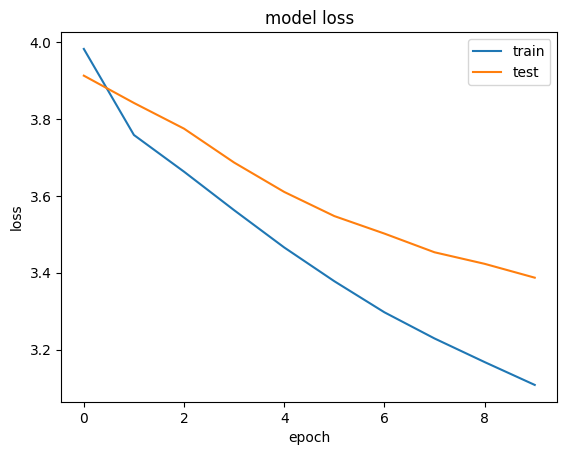

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

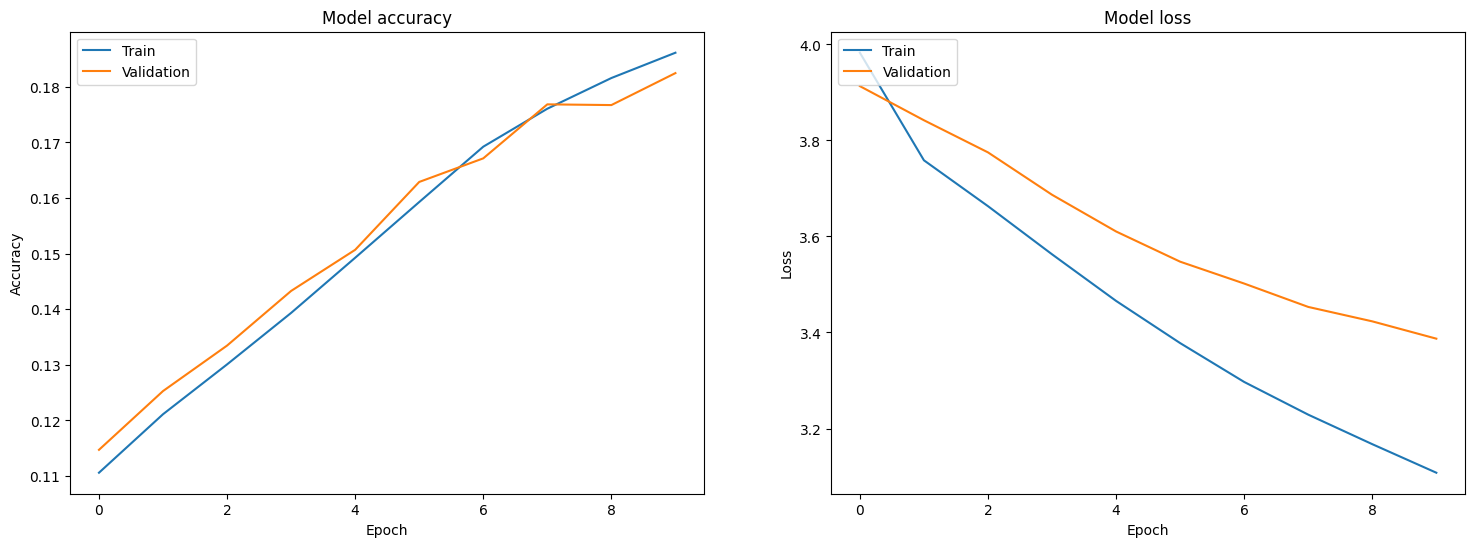

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')# the number of classifications a model correctly predicts divided by the total number of predictions made
axes[0].set_ylabel('Accuracy')#determine which model is best at identifying relationships and patterns between variables in a dataset based on the input, or training, data
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()